#Выгрузка данных

In [ ]:
import pandas as pd
import re
import numpy as np
import math

In [ ]:
parameters = pd.read_csv('/apics_data/parameters.csv')
parameters = parameters[['ID', 'Name', 'Type']]

In [ ]:
values_full = pd.read_csv('/apics_data/values-full.csv')
values_full = values_full[['ID', 'Language_ID', 'Parameter_ID', 'Value', 'Code_ID', 'Frequency', 'Confidence']]

In [ ]:
domainelement = pd.read_csv('/apics_data/domainelement.csv')

In [ ]:
Parameter_name = []
Parameter_value_name = []
Parameter_type = []
for i, code in enumerate(values_full['Code_ID']):
    current_parameter = parameters[parameters['ID']==values_full['Parameter_ID'][i]]
    Parameter_name.append(current_parameter['Name'].values[0])
    Parameter_type.append(current_parameter['Type'].values[0])
    current_domainelement = domainelement[domainelement['id']==code]
    Parameter_value_name.append(current_domainelement['name'].values[0])

In [ ]:
values_full['Parameter_name'] = Parameter_name
values_full['Parameter_value_name'] = Parameter_value_name
values_full['Parameter_type'] = Parameter_type

In [ ]:
#убираем диалектв и оставляем только основные языки
only_primary_langs = values_full[values_full['Language_ID']<1000]

Param_by_lang = only_primary_langs.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T

In [ ]:
only_primary_langs2 = only_primary_langs[(only_primary_langs['Parameter_type']=='sociolinguistic') | (only_primary_langs['Parameter_type']=='primary')]
#only_primary_langs2 = only_primary_langs2[only_primary_langs2['Parameter_type']=='primary']

#Общая табличка

In [ ]:
Good_features = {91: {'No applicative construction exists': 0,
       'Benefactive function and any base': 2,
       'Benefactive and other functions': 4,
       'Benefactive function and transitive base': 2} ,
58: {'Neutral alignment': 0, 'Accusative alignment': 2, 'Ergative alignment': 2},
56: {'Normal imperative construction and normal negator': 0,
       'Special imperative construction and normal negator': 2,
       'Normal imperative construction and special negator': 2,
       'Special imperative construction and special negator': 4},
36: {'The language has no numeral classifiers': 0,
       'The language has numeral classifiers': 2},
13: {'No gender distinctions': 0, 'In 3rd person singular only': 2,
       'In 2nd person but not in 3rd person': 2,
       'In 3rd person singular and plural only': 4},
34: {'No special adjacent distributive numerals': 0,
       'Distributivity marked by reduplication': 2},
70: {'Identity': 0, 'Differentiation': 2, 'Overlap': 2},
62: {'Obligatory pronoun words': 0, 'Optional pronoun words': 3,
       'Mixed behaviour of pronominal subjects': 3,
       'Subject pronouns in different position': 2, 'Pronoun affixes': 2},
15: {'No inclusive/exclusive distinction': 0,
       'Inclusive and exclusive differentiated': 2},
18: {'Binary pronominal politeness distinction': 2,
       'No pronominal politeness distinction': 0,
       'Titles used as second person forms': 3,
       'Multiple pronominal politeness distinction': 3},
33: {'Two-way contrast': 2, 'No distance contrast': 0, 'Four-way contrast': 4,
       'Three-way contrast': 3},
29: {'Indefinite article identical to numeral ‘one’': 2,
       'Indefinite article distinct from numeral ‘one’': 3,
       'Neither indefinite nor definite article': 0,
       'No indefinite article, but definite article': 0},
71: {'Overlap': 2, 'Differentiation': 2, 'Identity': 0}
}

In [ ]:
def make_structural_features_complexity_by_lang_table(feature_number, only_primary_langs=only_primary_langs):
    feature_name = list(only_primary_langs[only_primary_langs['Parameter_ID']==feature_number]['Parameter_name'].head(1))[0]
    features = only_primary_langs[only_primary_langs['Parameter_ID'].isin([feature_number])]
    features_by_lang_table = features.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T
    features_by_lang_table = features_by_lang_table.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(features_by_lang_table.index)
    add_df = pd.DataFrame(index=add_indices, columns=features_by_lang_table.columns)
    features_by_lang_table = pd.concat([features_by_lang_table, add_df])
    features_by_lang_table = features_by_lang_table.sort_index()
    features_columns = []
    for col in features_by_lang_table.columns:
        features_columns.append(list(only_primary_langs[only_primary_langs['Code_ID']==col]['Parameter_value_name'].head(1))[0])
    features_by_lang_table.columns = features_columns
    complexity_score = {}
    complexity_score2 = {}
    for i in features_by_lang_table.index:
        complexity_score[i] = np.nan
        complexity_score2[i] = np.nan
    for i in features_by_lang_table.index:
        for c in features_by_lang_table.columns:
            if features_by_lang_table[c][i] >= 70:
                complexity_score[i] = Good_features[feature_number][c]
            if features_by_lang_table[c][i] is np.nan:
                print(features_by_lang_table[c][i])
    features_by_lang_table['complexity_score for ' + feature_name] = complexity_score.values() #поменять, чтобы вернуть к числам
    return features_by_lang_table[['complexity_score for ' + feature_name]]

In [ ]:
def make_socioling_features_by_lang_table(feature_number, only_primary_langs=only_primary_langs, reversed=False):
    socioling_features = only_primary_langs[only_primary_langs['Parameter_ID'].isin([feature_number])]
    socioling_features_by_lang = socioling_features.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T
    socioling_features_by_lang = socioling_features_by_lang.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(socioling_features_by_lang.index)
    add_df = pd.DataFrame(index=add_indices, columns=socioling_features_by_lang.columns)
    socioling_features_by_lang = pd.concat([socioling_features_by_lang, add_df])
    socioling_features_by_lang = socioling_features_by_lang.sort_index()

    socioling_feature_name = list(socioling_features['Parameter_name'])[0]
    socioling_features_by_lang[socioling_feature_name] = ''
    socioling_features_by_lang['rank for ' + socioling_feature_name] = ''
    for col in socioling_features_by_lang.columns[0:-1]:
        for i, f in enumerate(socioling_features_by_lang[col]):
            if f==100:
                socioling_features_by_lang[socioling_feature_name][i+1] = list(only_primary_langs[only_primary_langs['Code_ID'].isin([col])].head(1)['Parameter_value_name'])[0]
                socioling_features_by_lang['rank for ' + socioling_feature_name][i+1] = int(col[-1:]) - 1
    if reversed:
        for i, r in enumerate(socioling_features_by_lang['rank for ' + socioling_feature_name]):
            if r == '':
                socioling_features_by_lang['rank for ' + socioling_feature_name][i+1] = np.nan
        max_rank = socioling_features_by_lang['rank for ' + socioling_feature_name].max()
        socioling_features_by_lang['reversed rank for ' + socioling_feature_name] = [abs(r-max_rank) for r in socioling_features_by_lang['rank for ' + socioling_feature_name]]
        socioling_features_by_lang['rank for ' + socioling_feature_name] = socioling_features_by_lang['reversed rank for ' + socioling_feature_name]
        #return socioling_features_by_lang[[socioling_feature_name, 'rank for ' + socioling_feature_name, 'reversed rank for ' + socioling_feature_name]]
    return socioling_features_by_lang[[socioling_feature_name, 'rank for ' + socioling_feature_name]]

In [ ]:
feature_strings = ['Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
def make_socioling_features_by_lang_table_for_variation_and_domains(feature_str, only_primary_langs=only_primary_langs, reversed=False):
    socioling_features = only_primary_langs[only_primary_langs['Parameter_name'].str.contains(feature_str)]
    socioling_features_by_lang = socioling_features.pivot_table('Value', index='Code_ID', columns='Language_ID').T
    socioling_features_by_lang = socioling_features_by_lang.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(socioling_features_by_lang.index)
    add_df = pd.DataFrame(index=add_indices, columns=socioling_features_by_lang.columns)
    socioling_features_by_lang = pd.concat([socioling_features_by_lang, add_df])
    socioling_features_by_lang = socioling_features_by_lang.sort_index()
    value_to_grade = {1.0:1, 2.0:0.5, 3.0:0, 4.0:0}
    socioling_features_by_lang = socioling_features_by_lang.replace(value_to_grade)
    socioling_features_by_lang[feature_str] = socioling_features_by_lang.sum(axis=1)
    socioling_features_by_lang[feature_str] = socioling_features_by_lang[feature_str].astype('int64')

    return socioling_features_by_lang[[feature_str]]

In [ ]:
#создаём общую табличку для признаков из Good
sl_features = [308, 309, 310, 311, 312, 313, 314, 326]
feature_strings_for_domains_and_variation = ['Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
all_languages_Good_complexity_features_table=pd.DataFrame()

for f in list(Good_features.keys()):
    new_df = make_structural_features_complexity_by_lang_table(f)
    all_languages_Good_complexity_features_table = pd.concat([all_languages_Good_complexity_features_table, new_df], axis=1)
all_languages_Good_complexity_features_table['total_complexity_score'] = all_languages_Good_complexity_features_table.mean(axis=1, skipna=True)
for f in sl_features:
    if f in [309, 310, 311]:
        new_df = make_socioling_features_by_lang_table(f, reversed=True)
    else:
        new_df = make_socioling_features_by_lang_table(f)
    all_languages_Good_complexity_features_table = pd.concat([all_languages_Good_complexity_features_table, new_df], axis=1)
for f in feature_strings_for_domains_and_variation:
    new_df = make_socioling_features_by_lang_table_for_variation_and_domains(f)
    all_languages_Good_complexity_features_table = pd.concat([all_languages_Good_complexity_features_table, new_df], axis=1)

In [ ]:
#all_languages_Good_complexity_features_table = all_languages_Good_complexity_features_table.applymap(str)
#all_languages_Good_complexity_features_table.to_excel('Good_complexity_features.xlsx')

#Таблицы сопряженности и тест Фишера

In [ ]:
def crosstab_for_Good_complexity_features(st_feature, sl_feature, language_table=all_languages_Good_complexity_features_table):
    temp_table = language_table[[st_feature, sl_feature]]
     #удаляем строки, где нет данных по одному из признаков
    temp_table = temp_table.replace('', np.nan)
    temp_table = temp_table.dropna()
    contingency_table = pd.crosstab(temp_table[st_feature], temp_table[sl_feature])
    return contingency_table
    #contingency_table_plus = contingency_table.copy()
    #contingency_table_plus['Proportion of ' + st_feature] = contingency_table[st_feature] / (contingency_table[st_feature] + contingency_table['not ' + st_feature])
    #return contingency_table, contingency_table_plus

In [ ]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
stats = importr('stats')

p_values = {}
sl_features_names = ['Lexifier language', 'Proportion of native speakers', 'Ongoing creolization of pidgins', 
                     'Increasing use', 'Language abandonment', 'Size of speaker community', 'Gender-related use', 'Contact with other languages',
                     'Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
final_stat_for_Good_features = pd.DataFrame(index=all_languages_Good_complexity_features_table.columns[:13], columns=sl_features_names)
final_stat_for_Good_features_graphs = pd.DataFrame(index=all_languages_Good_complexity_features_table.columns[:13], columns=sl_features_names)
all_sign_str_f = []
for sl_feature in sl_features_names:
    for st_feature in all_languages_Good_complexity_features_table.columns[:13]:
        cross_table = crosstab_for_Good_complexity_features(st_feature, sl_feature)
        m = np.array(cross_table)
        res = stats.fisher_test(m, workspace = 2e8)         
        if res[0][0] < 0.05:
            final_stat_for_Good_features[sl_feature][st_feature] = round(res[0][0], 3)
            final_stat_for_Good_features_graphs[sl_feature][st_feature] = cross_table
            if sl_feature=='Lexifier language':
                all_sign_str_f.append(st_feature)
        else:
            final_stat_for_Good_features[sl_feature][st_feature] = '--'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
a = final_stat_for_Good_features_graphs['Language abandonment']['complexity_score for Expression of pronominal subjects']
a = a[['Absent', 'Limited', 'Widespread']]
#a = a.reindex(['Virtually none', 'Some', 'Many', 'Most', 'Virtually all'], axis=1)
a

Language abandonment,Absent,Limited,Widespread
complexity_score for Expression of pronominal subjects,,,
0,21,22,5
2,2,1,2
3,5,6,7


In [ ]:
sns.set(rc={'figure.figsize':(4,12)})
#fig = plt.figure(figsize=(100, 20))
sl_feature = 'Lexifier language'
st_features_sgn = final_stat_for_Good_features_graphs[final_stat_for_Good_features_graphs['Lexifier language'].notna()].index
complexity_scores = []
percents = []
features = []
lexifiers = []
final_df = pd.DataFrame()
for st_feature in st_features_sgn:
    df = all_languages_Good_complexity_features_table[[sl_feature, st_feature]].copy()
    x=st_feature
    y='Lexifier language'
    df = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    percents.extend(df['percent'])
    complexity_scores.extend(df[df.columns[1]])
    lexifiers.extend(df['Lexifier language'])
    features.extend([st_feature]*len(df))


final_df['Lexifiers'] = lexifiers
final_df['Complexity_scores'] = complexity_scores
final_df['Percent of languages\n with specific\n lexifier'] = percents
final_df['Feature'] = features
final_df = final_df[final_df['Complexity_scores']!='nan']
final_df['Complexity_scores'] = final_df['Complexity_scores'].astype('float')
final_df = final_df.sort_values(by=['Complexity_scores', 'Lexifiers'])
#.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

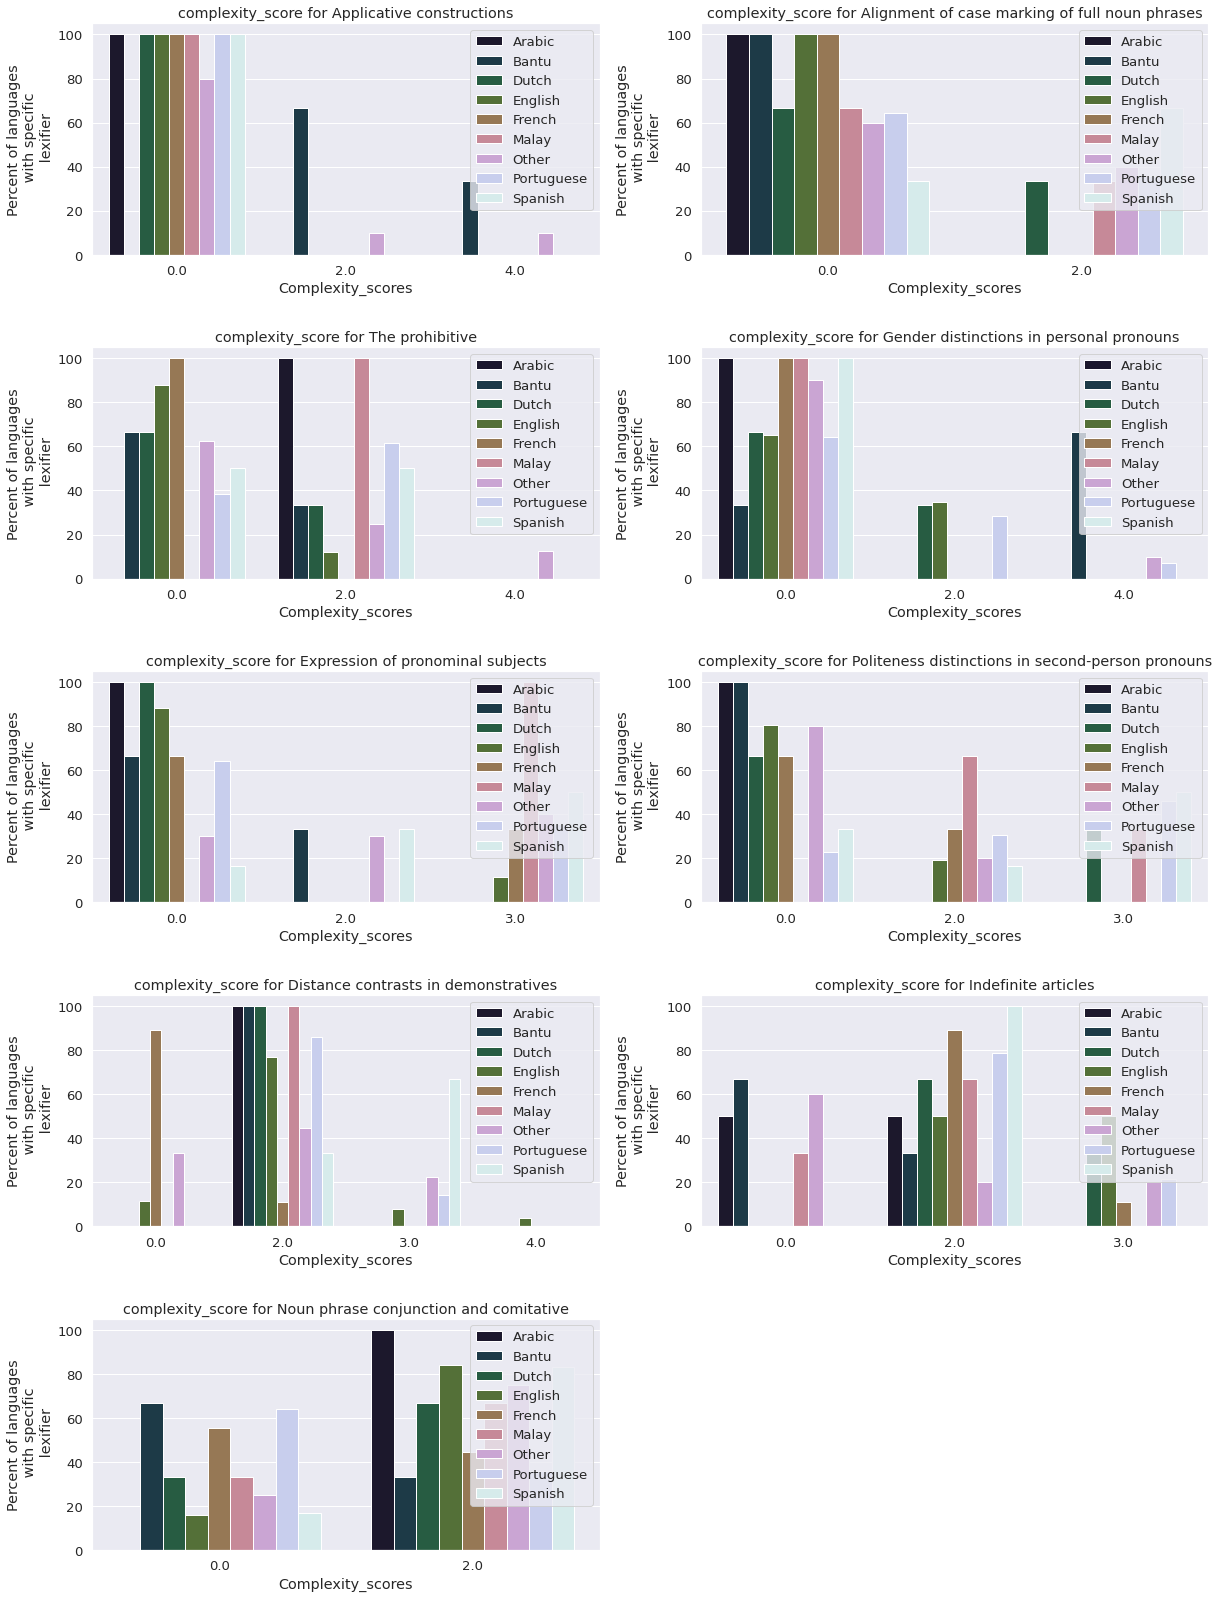

In [ ]:
hue_order = ['Arabic', 'Bantu', 'Dutch', 'English', 'French', 'Malay', 
             'Other', 'Portuguese', 'Spanish']
sns.set(font_scale=1.2)
i = 1
fig = plt.figure(figsize=(20, 40))
for st_feature in st_features_sgn:
    a = final_df[final_df['Feature']==st_feature]
    plt.subplot(7, 2, i)
    plt.subplots_adjust(hspace = 0.4)
    sns.barplot(data=a, x='Complexity_scores', y='Percent of languages\n with specific\n lexifier', 
                hue='Lexifiers', hue_order=hue_order, palette="cubehelix")
    plt.title(st_feature)
    plt.legend(loc='upper right')
    i += 1
plt.savefig('compl_score_by_lex.png')

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(final_df, row="Feature",
                  height=3, aspect=3.4)
g.map(sns.barplot, 'Complexity_scores', "Percent", 'Lexifiers', palette="cubehelix")

График зависимости общей сложности от размера языкового сообщества

In [ ]:
import matplotlib.pyplot as plt
#sns.set(rc={'figure.figsize':(20,100)})
sns.catplot(x="Size of speaker community", y="total_complexity_score", kind="box", 
            data=df, height=5, aspect=20/6)

In [ ]:
lexifiers_to_paradigmatic_complecity = {'English': 0.31,
'French': 0.42,
'Spanish': 0.54,
'Arabic': 0.34,
}

In [ ]:
df = all_languages_Good_complexity_features_table[['total_complexity_score', 'Lexifier language']]
df = df[df['Lexifier language'].isin(lexifiers_to_paradigmatic_complecity)]
arr = []
len(df)
for lan in df['Lexifier language']:
    arr.append(lexifiers_to_paradigmatic_complecity[lan])
df['lexifier_complexity'] = arr
df['total_complexity_score'] = a['sum']
df.head()

,total_complexity_score,Lexifier language,lexifier_complexity
1,0.217949,English,0.31
2,0.180556,English,0.31
3,0.179487,English,0.31
4,0.237179,English,0.31
5,0.269231,English,0.31


In [ ]:
from statsmodels.formula.api import ols
x=df['total_complexity_score']
y=df['lexifier_complexity']
model = ols("total_complexity_score ~ lexifier_complexity", data=df)
res = model.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     total_complexity_score   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.036
Method:                     Least Squares   F-statistic:                     2.558
Date:                    Tue, 18 May 2021   Prob (F-statistic):              0.117
Time:                            19:56:02   Log-Likelihood:                 35.321
No. Observations:                      43   AIC:                            -66.64
Df Residuals:                          41   BIC:                            -63.12
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

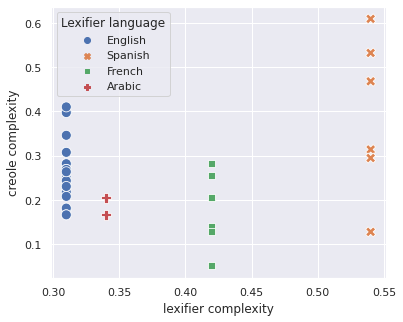

In [ ]:
sns.set(font_scale=1.2)
sns.set(rc={'figure.figsize':(6,5)})
sns.scatterplot(data=df, x='lexifier_complexity', y='total_complexity_score', 
                hue='Lexifier language', style='Lexifier language', s=100)
plt.xlabel("lexifier complexity")
plt.ylabel("creole complexity")
plt.savefig('lang_coml_sta.png')

In [ ]:
from scipy.stats import f_oneway
eng = list(df[df['Lexifier language']=='English']['total_complexity_score'])
spn = list(df[df['Lexifier language']=='Spanish']['total_complexity_score'])
fr = list(df[df['Lexifier language']=='French']['total_complexity_score'])
ar = list(df[df['Lexifier language']=='Arabic']['total_complexity_score'])
f_oneway(eng, spn, fr, ar)
#f_oneway(spn, fr)

F_onewayResult(statistic=7.382541303315716, pvalue=0.000494446151400142)

In [ ]:
#чтобы сохранить значения как категории, а не как числа
df = pd.read_csv('Good_complexity_features_all.csv', sep=';')
dict_num_to_str = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}
df[df.columns[1:14]] = df[df.columns[1:14]].replace(dict_num_to_str)
df[df.columns[-5:]] = df[df.columns[-5:]].replace(dict_num_to_str)
df.to_excel('all_comlexity_with_str.xlsx')